In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from nltk.tokenize import sent_tokenize
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#nltk.download('punkt')
#nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
!pip install tensorflow tensorflow_hub
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
!git add VADER.ipynb
!git commit -m 'NER graphs'
!git push

In [54]:
corpus = pd.read_csv('corpus_NER.csv')
corpus_df = corpus.copy()

In [55]:
corpus_df['combined_text'] = corpus_df['title'] + " " + corpus_df['content']

In [56]:
analyzer = SentimentIntensityAnalyzer()

# Function to apply VADER sentiment analysis to text
def get_vader_sentiment(text):
    sentiment = analyzer.polarity_scores(text) # Get sentiment scores
    return sentiment['compound']  # Compound score is the overall sentiment

In [57]:
corpus_df['headline_score'] = corpus_df['headline'].apply(get_vader_sentiment)
corpus_df['headline_sentiment'] = corpus_df['headline_score'].apply(lambda x: 'positive' if x>0.05 else ('negative' if x< -0.05 else 'neutral'))

In [32]:
#elmo = hub.load("https://tfhub.dev/google/elmo/2")

In [58]:
def truncate_content(content, token_limit=800):
    # Initialize variables to count tokens and store truncated sentences
    total_tokens = 0
    truncated_sentences = []
    sentences = sent_tokenize(content)
    
    for sentence in sentences:
        sentence_tokens = len(sentence.split())  # Token count of the sentence
        
        # Check if adding this sentence will exceed the token limit
        if total_tokens + sentence_tokens > token_limit:
            break  # Stop if we've reached the limit
        truncated_sentences.append(sentence)
        total_tokens += sentence_tokens
    
    # Join the truncated sentences back into a string
    return ' '.join(truncated_sentences)
corpus_df['content'] = corpus_df['content'].apply(truncate_content)

In [76]:
def get_elmo_embeddings_batch(text_batch):
    """
    Function to get ELMo embeddings for a batch of text
    """
    elmo_input = tf.convert_to_tensor(text_batch, dtype=tf.string)
    
    # Get the embeddings from ELMo
    elmo_output = elmo.signatures['default'](text=elmo_input)
    embeddings = elmo_output['elmo']
    
    return embeddings

def process_in_batches(df, batch_size=16, max_length=800):
    """
    Process the content column in batches, getting ELMo embeddings for each batch.
    Pads the embeddings to ensure consistent shapes for concatenation.
    """
    embeddings = []
    total_rows = len(df)
    
    for start in range(0, total_rows, batch_size):
        # Create batch slice
        end = min(start + batch_size, total_rows)
        batch_text = df['content'][start:end].tolist()
        
        # Get ELMo embeddings for the batch
        try:
            batch_embeddings = get_elmo_embeddings_batch(batch_text)
            
            # Pad embeddings to ensure consistent shape (max_length, 1024) for each sentence in the batch
            # Pad to max_length if sentence is shorter, truncate if longer
            batch_embeddings_padded = pad_sequences(batch_embeddings.numpy(), 
                                                     maxlen=max_length, 
                                                     dtype='float32', 
                                                     padding='post', 
                                                     truncating='post')
            
            embeddings.append(batch_embeddings_padded)  # Add the padded embeddings
        except Exception as e:
            print(f"Error processing batch {start}-{end}: {e}")
            embeddings.append(None)  # Append None in case of failure
        
        # Print progress every 10 batches
        if (start // batch_size) % 10 == 0:
            print(f"Processed {start} to {end} rows...")
    
    # Concatenate all batches together
    embeddings = np.concatenate(embeddings, axis=0)
    
    return embeddings

# Process just the 'content' column and return embeddings as a separate variable
elmo_embeddings = process_in_batches(corpus_df, batch_size=16, max_length=800)

# Now, elmo_embeddings holds the embeddings for the 'content' column only
print(elmo_embeddings.shape)  # This will show the shape (num_samples, max_length, 1024)


Processed 0 to 16 rows...
Processed 160 to 176 rows...
Processed 320 to 336 rows...
Processed 480 to 496 rows...
(502, 800, 1024)


In [91]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Example: one-hot encode the labels (alternative method)
y = pd.get_dummies(corpus_df['headline_sentiment']).to_numpy()

indices = np.arange(len(corpus_df))

# Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
    elmo_embeddings,  # The ELMo embeddings (input features)
    y,                # The labels (sentiment)
    indices,          # The indices from the DataFrame
    test_size=0.2,    # 20% for testing
    random_state=42   # For reproducibility
)
# Build the LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(800, 1024)),  # (max_length, embedding_dim)
    tf.keras.layers.LSTM(128, return_sequences=False),  # 128 LSTM units
    tf.keras.layers.Dropout(0.3),  # Dropout for regularization
    tf.keras.layers.Dense(64, activation='relu'),  # Dense layer
    tf.keras.layers.Dense(3, activation='softmax')  # Output layer (3 classes)
])

# Compile the model
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Making predictions
test_predictions = model.predict(X_test)
predicted_classes = np.argmax(test_predictions, axis=1)

# Print the first 10 predictions
print(predicted_classes[:10])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 26s 907ms/step - accuracy: 0.3611 - loss: 1.1018 - val_accuracy: 0.3960 - val_loss: 1.0867
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 808ms/step - accuracy: 0.3848 - loss: 1.0704 - val_accuracy: 0.3069 - val_loss: 1.1090
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 873ms/step - accuracy: 0.3543 - loss: 1.0510 - val_accuracy: 0.3267 - val_loss: 1.1121
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 804ms/step - accuracy: 0.4189 - loss: 1.0034 - val_accuracy: 0.3960 - val_loss: 1.2062
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 854ms/step - accuracy: 0.4669 - loss: 0.9579 - val_accuracy: 0.3465 - val_loss: 1.2526
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 22s 821ms/step - accuracy: 0.4609 - loss: 0.9494 - val_accuracy: 0.3366 - val_loss: 1.2742
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 811ms/step - accuracy: 0.4968 - loss: 0.8835 - val_accuracy: 0.3861 - val_loss: 1.3547
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 780ms/step - accuracy: 0.4584 - loss: 0.8782 - val_accu

In [83]:
sentiment_labels = pd.get_dummies(corpus_df['headline_sentiment']).columns
print(sentiment_labels)

Index(['negative', 'neutral', 'positive'], dtype='object')


<Axes: xlabel='headline_sentiment', ylabel='Count'>

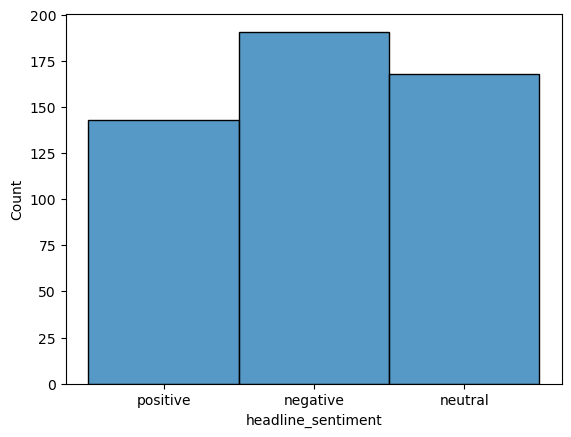

In [89]:
# sentiment balance
sns.histplot(corpus_df['headline_sentiment']) # reasonable balanced 

In [99]:
corpus_df[['headline', 'headline_sentiment']].iloc[test_idx].tail(10)

,headline,headline_sentiment
474,Albanese gives $6m to Devonport as he looks to...,positive
439,Warren Mundine backtracks on ‘disrespectful’ g...,negative
325,Senator threatens climate body after nuclear '...,negative
433,Govt ‘powerless’ to tackle antisemitic attacks...,negative
499,Anthony Albanese switches to election footing ...,negative
86,Election 2025: Australian PM Anthony Albanese ...,neutral
75,Dutton promises lower energy prices with plan ...,positive
440,Dutton wants to slash thousands of government ...,negative
15,Labor accuses Dutton of copying Trump with sug...,negative
250,Teal MPs decry anonymous ‘push poll’ sent to v...,neutral


In [98]:
predicted_classes

array([1, 0, 0, 2, 1, 2, 0, 0, 0, 2, 1, 0, 2, 1, 1, 1, 1, 0, 2, 1, 2, 2,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 2, 1, 1, 2, 1, 0, 2, 2, 1,
       2, 1, 0, 0, 2, 0, 0, 2, 0, 0, 1, 2, 1, 0, 2, 2, 0, 0, 2, 2, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 2, 2, 2, 0, 1, 2, 2, 2, 0, 0, 2, 2, 2, 2,
       0, 0, 0, 0, 0, 1, 0, 2, 2, 0, 2, 1, 2])

In [100]:
# topic modelling

import gensim
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

# Download stopwords if not done already
nltk.download('stopwords')

# Get the stop words
stop_words = set(stopwords.words('english'))

# Sample corpus (list of documents)
corpus = [
    "Machine learning is amazing.",
    "Natural language processing is a field of machine learning.",
    "Data science uses machine learning techniques."
]

# Step 1: Preprocess the documents (remove punctuation, lowercase, tokenize, remove stopwords)
def preprocess(text):
    # Tokenize and remove stopwords
    tokens = simple_preprocess(text, deacc=True)  # deacc=True removes punctuation
    return [word for word in tokens if word not in stop_words]

processed_corpus = [preprocess(doc) for doc in corpus]

# Step 2: Create a dictionary and Bag of Words (BoW) corpus
dictionary = gensim.corpora.Dictionary(processed_corpus)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_corpus]

# Step 3: Apply LDA topic modeling
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=3, id2word=dictionary, passes=10)

# Step 4: Print the topics
for idx, topic in lda_model.print_topics(num_words=5):
    print(f"Topic #{idx + 1}: {topic}")

KeyboardInterrupt: 

In [131]:
import ast
cols_to_fix = ['headline_people', 'headline_parties', 'content_people', 'content_parties']
for col in cols_to_fix:
    corpus_df[col] = corpus_df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [152]:
leader_aliases = {
    "Albanese": "Anthony Albanese",
    "Anthony Albanese": "Anthony Albanese",
    "Dutton": "Peter Dutton",
    "Peter Dutton": "Peter Dutton",
    "Bandt": "Adam Bandt",
    "Adam Bandt": "Adam Bandt",
    "Morrison": "Scott Morrison",
    "Scott Morrison": "Scott Morrison",
    "Marles": "Richard Marles",
    "Richard Marles": "Richard Marles",
    "Wong": "Penny Wong",
    "Penny Wong": "Penny Wong"
}

def normalize_leaders(person_list):
    return [leader_aliases[name] for name in person_list if name in leader_aliases]

corpus_df['headline_people'] = corpus_df['headline_people'].apply(normalize_leaders)

In [153]:
filtered_df = corpus_df[corpus_df['headline_people'].apply(lambda x: len(x) > 0)]


In [141]:
filtered_df.to_csv('filtered_df.csv', index=False)

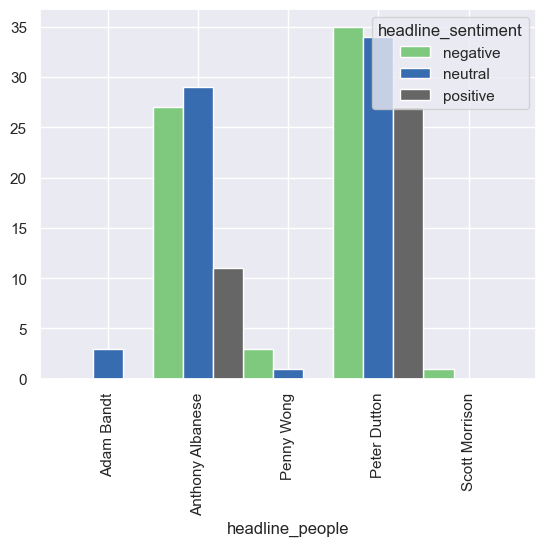

In [167]:
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
sns.set_theme()
exploded_df = filtered_df.explode('headline_people')
sentiment_counts = exploded_df.groupby(['headline_people', 'headline_sentiment']).size().unstack(fill_value=0)
sentiment_counts.plot(kind = 'bar', colormap = cm.Accent, width = 1)
plt.show()

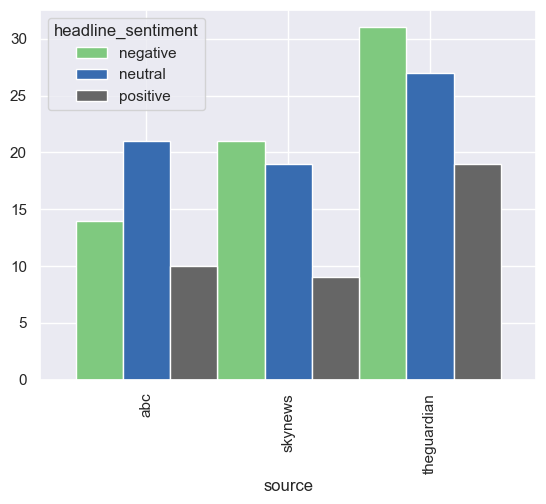

In [168]:
source_counts = exploded_df.groupby(['source', 'headline_sentiment']).size().unstack(fill_value=0)
source_counts.plot(kind = 'bar', colormap = cm.Accent, width = 1)
plt.show()

In [185]:
source_and_leader_counts = exploded_df.groupby(['source', 'headline_sentiment', 'headline_people']).size().unstack(fill_value=0)

In [191]:
source_and_leader_counts[['Anthony Albanese', 'Peter Dutton']]

headline_people                 Anthony Albanese  Peter Dutton
source      headline_sentiment                                
abc         negative                           6             8
            neutral                            9            12
            positive                           1             9
skynews     negative                          14             3
            neutral                           11             8
            positive                           5             4
theguardian negative                           7            24
            neutral                            9            14
            positive                           5            14